## <font color='green'><b>Base Dir setup</b></font>

In [40]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'CV/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #MODIFY THESE PATHS TO POINT TO YOUR IMAGES
  img_dir = 'data/img/'
  vid_dir = 'data/video/'
  out_dir = 'output/'
  
  # move to base_dir 
  os.chdir(base_dir)
else:
  #MODIFY THESE PATHS TO POINT TO YOUR IMAGES
  img_dir = '../data/img/'
  out_dir = '../data/output/'

print("Current dir:", os.getcwd())

Current dir: /Users/raffaella/Library/CloudStorage/OneDrive-UniversitàdegliStudidiMilano/Raffaella Unimi/materiale didattica/Visione Artificiale/Visione_Artificiale_2024-25/Lectures/PARTE I/Labs/Lab04_CameraCalibration


In [41]:
import numpy as np
import cv2
import glob
import matplotlib.pylab as plt

# Camera Calibration

For Camera calibration we need at least 10 test patterns.
In this example we refer to samples from opencv itself.

Important input datas needed for camera calibration is a set of 3D real world points and its corresponding 2D image points. **2D image points** are OK which we can easily find from the image. (These image points are locations where two black squares touch each other in chess boards)

What about the **3D points** from real world space? Those images are taken from a static camera and chess boards are placed at different locations and orientations. So we need to know (X,Y,Z) values. But for simplicity, we can say chess board was kept stationary at XY plane, (so Z=0 always) and camera was moved accordingly. This consideration helps us to find only X,Y values. Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points. In this case, the results we get will be in the scale of size of chess board square. But if we know the square size, (say 30 mm), and we can pass the values as (0,0),(30,0),(60,0),..., we get the results in mm. (In this case, we don’t know square size since we didn’t take those images, so we pass in terms of square size).

3D points are called **object points** and 2D **image points** are called image points.


In [42]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria (for cornerSubPix)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [2., 1., 0.],
       [3., 1., 0.],
       [4., 1., 0.],
       [5., 1., 0.],
       [6., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [2., 2., 0.],
       [3., 2., 0.],
       [4., 2., 0.],
       [5., 2., 0.],
       [6., 2., 0.],
       [0., 3., 0.],
       [1., 3., 0.],
       [2., 3., 0.],
       [3., 3., 0.],
       [4., 3., 0.],
       [5., 3., 0.],
       [6., 3., 0.],
       [0., 4., 0.],
       [1., 4., 0.],
       [2., 4., 0.],
       [3., 4., 0.],
       [4., 4., 0.],
       [5., 4., 0.],
       [6., 4., 0.],
       [0., 5., 0.],
       [1., 5., 0.],
       [2., 5., 0.],
       [3., 5., 0.],
       [4., 5., 0.],
       [5., 5., 0.],
       [6., 5., 0.]], dtype=float32)

In [43]:
#load all the chessboard images
images = glob.glob(img_dir + 'chessboard/*.jpg')
len(images) #nb of images for calibration

26

## Find the 2D pattern on the images

So to find pattern in chess board, we use the function, `cv2.findChessboardCorners()`. We also need to pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid etc. In this example, we use **7x6 grid**. (Normally a chess board has 8x8 squares and 7x7 internal corners). It returns the corner points and retval which will be True if pattern is obtained. These corners will be placed in an order (from left-to-right, top-to-bottom).

Once we find the corners, we can increase their accuracy using `cv2.cornerSubPix()`. We can also draw the pattern using `cv2.drawChessboardCorners()`. All these steps are included in below code:



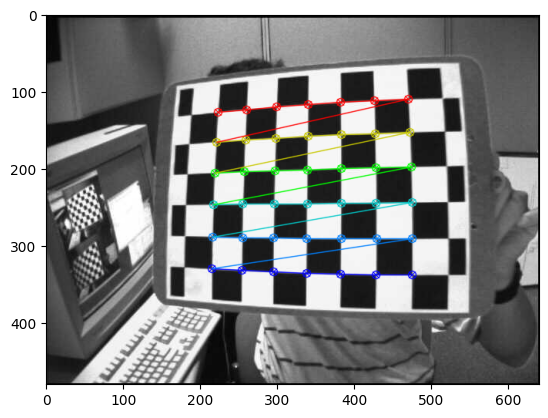

In [44]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow( img)
          

## Calibration
So now we have our *object points* and *image points* we are ready to go for calibration. For that we use the function, `cv2.calibrateCamera(`). It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

Output:
- `cameraMatrix` –  Output $3 \times 3$ floating-point Intrinsic camera matrix 
$A = \begin{bmatrix}
    {f_x} & {0}&{c_x}\\ {0} & {f_y} & {c_y}\\ {0} & {0}& {1}\\
\end{bmatrix}$
 
  
- `distCoeffs` – Output vector of distortion coefficients $(k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6]])$ of 4, 5, or 8 elements.

- `tvecs` – Output vector of translation vectors estimated **for each pattern view**.

- `rvecs` – Output vector of rotation vectors estimated **for each pattern view**. That is, each k-th rotation vector together with the corresponding k-th translation vector brings the estrinsic calibration pattern from the model coordinate space (in which object points are specified) to the world coordinate space, that is, a real position of the calibration pattern in the k-th pattern view (k=0.. M -1).



For more details:
https://docs.opencv.org/2.4.13.3/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

In [45]:
ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [46]:
print(distCoeffs)



[[-3.10623618e-01  2.22524935e-01  6.87556137e-04 -2.27914512e-04
  -1.94685191e-01]]


# Application:

## 1. Image undistortion using `cv2.undistort()` 

The result, `dst`, is the corrected image, with **the effect of radial and tangential distortion removed** or significantly reduced. This improvement is particularly important in applications such as robotic navigation, 3D reconstruction, and any other scenario where the geometric accuracy of images is crucial.

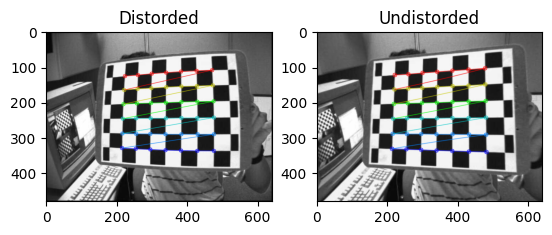

In [47]:
# undistort
dst = cv2.undistort(img, cameraMatrix, distCoeffs, None, None)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Distorded")
plt.subplot(1,2,2)
plt.imshow(dst)
plt.title("Undistorded");

In [48]:
# CHECK POINT: Compute the error or reprojection to verify the goodness of the calibration
tot_error = 0
for i in range(len(objpoints)):
    # given the real point objpoints[i] of the i-th view of the calibration pattern, 
    # and all the calibration parameters associated to it (intrinsic and distortion param. are common to all images,
    # while extrinsic vary from one image to the other, being the WCS determined for each acquisition)
    # determine the corrisponding image points
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs)
    
    # compare the points obtained exploiting the calibration with those measured on the image
    # if we produced a good calibration, the error should be small
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error = tot_error + error

print("Mean error per img: ", tot_error/len(objpoints))

Mean error per img:  0.028317737290214934


## 2. Augmented reality: draw axis

Given a pattern image, we can utilize the above information to calculate its pose, or how the object is situated in space, like how it is rotated, how it is displaced etc. For a planar object, we can assume Z=0, such that, the problem now becomes **how camera is placed in space to see our pattern image**. So, if we know how the object lies in the space, we can draw some 2D diagrams in it to simulate the 3D effect. Let's see how to do it.

Our problem is, we want to **draw the 3D coordinate axis (X, Y, Z axes) on our chessboard's first corner**. X axis in blue color, Y axis in green color and Z axis in red color. So in-effect, Z axis should feel like it is perpendicular to our chessboard plane.

First, let's create a function, `draw3DAxis` which takes a corner in the chessboard (obtained using cv.findChessboardCorners()) and axis points to draw a 3D axis.

In [49]:
def draw3DAxis(img, corner, imgpts):
    
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

We create:
- termination criteria, 
- object points (3D points of corners in chessboard) and 
- axis points. 

Axis points are points in 3D space for drawing the axis. We draw axis of length 3 (units will be in terms of chess square size since we calibrated based on that size). So our X axis is drawn from (0,0,0) to (3,0,0), so for Y axis. For Z axis, it is drawn from (0,0,0) to (0,0,-3). Negative denotes it is drawn towards the camera.

In [50]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2) #the 42 chessboard corners
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)  #the 3 axes

In [51]:
np.shape(objp)

(42, 3)

`cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, distCoeffs[, rvec[, tvec[, useExtrinsicGuess[, flags]]]]) → retval, rvec, tvec`

* INPUT:

- `objectPoints`: array of object points. objectPoints can either be a matrix or a vector of N 3D points.

- `imagePoints`: array of image points. imagePoints can either be a matrix or a vector of N 2D points.

- `cameraMatrix`: the $3 \times 3$ intrinsic camera matrix taken as an input.

- `distCoeffs`

* OUTPUT:
- `rvec`	Rotation vector that, together with tvec, brings points from the model coordinate system (`objectPoints`) to the camera coordinate system (`imagePoints`).
- `tvec`	Translation vector.

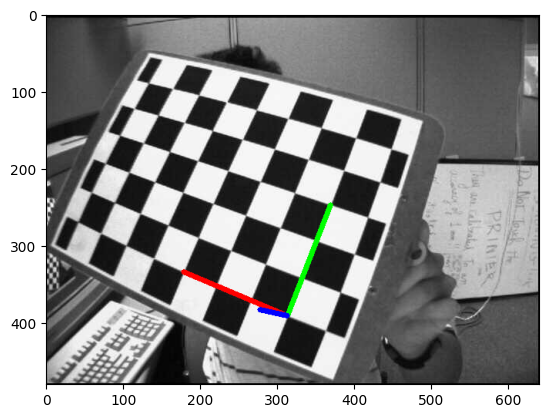

In [52]:
#Load an image of the chessboard 
fname = img_dir + 'chessboard/right03.jpg'
img = cv2.imread(fname)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Find its corners (7X6)
ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
if ret == True:
    corners2 =  cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

    # Find the rotation and translation vectors to bring the world 'coords' objp into the camera coords 'corners2'
    ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, cameraMatrix, distCoeffs)
    # apply the found rot and transl to the axis
    imgpts, _ = cv2.projectPoints(axis, rvecs, tvecs, cameraMatrix, distCoeffs)
    corner = tuple((corners2[0].astype(int)).ravel()) #choose 1 chessboard corner
    #draw the axis from one corner to the rotated axis extrema 
    img = draw3DAxis(img,corner,imgpts.astype(int))
    plt.imshow(img)
 
 

## 3. Augmented reality: draw a Cube

In [53]:
def drawCube(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

In [54]:
axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

../data/img/chessboard/left06.jpg


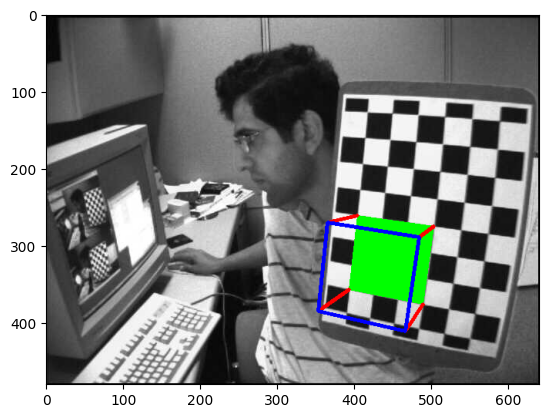

In [55]:
#for fname in glob.glob(img_dir + 'chessboard/left*.jpg'):
fname = img_dir + 'chessboard/left06.jpg'
print(fname)
img = cv2.imread(fname)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
if ret == True:
    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    # Find the rotation and translation vectors.
    ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, cameraMatrix, distCoeffs)
    # project 3D points to image plane
    imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, cameraMatrix, distCoeffs)
    img = drawCube(img, imgpts.astype(int))
    plt.imshow(img)